# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [2]:
# Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
# Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip --no-check-certificate
!unzip dogImages.zip

In [3]:
session = sagemaker.Session()

bucket = "haont1-bucket"
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: haont1-bucket
AWS Region: us-east-1
RoleArn: arn:aws:iam::172446954990:role/service-role/AmazonSageMaker-ExecutionRole-20241115T094660


In [4]:
os.environ["DEFAULT_S3_BUCKET"] = bucket

!aws s3 sync ./dogImages/train s3://${DEFAULT_S3_BUCKET}/data/train/
!aws s3 sync ./dogImages/valid s3://${DEFAULT_S3_BUCKET}/data/valid/
!aws s3 sync ./dogImages/test s3://${DEFAULT_S3_BUCKET}/data/test/

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [5]:
#Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    'batch_size': IntegerParameter(32, 128),
    'learning_rate': ContinuousParameter(1e-4, 5e-2),
    'num_epochs': IntegerParameter(5, 15)
}

objective_metric_name = 'Average loss'
objective_type = 'Minimize'

metric_definitions = [{"Name": "Average loss", "Regex": "Average loss: ([0-9\\.]+)"}]

In [6]:
train_dataset_directory = f"s3://{bucket}/data/train/"
valid_dataset_directory = f"s3://{bucket}/data/valid/"
test_dataset_directory = f"s3://{bucket}/data/test/"
model_dir = f"s3://{bucket}/hpo_model/model.tar.gz"

os.environ["SM_MODEL_DIR"] = model_dir
os.environ["SM_CHANNEL_TRAIN"] = train_dataset_directory
os.environ["SM_CHANNEL_VALIDATION"] = valid_dataset_directory
os.environ["SM_CHANNEL_TEST"] = test_dataset_directory

In [7]:
from sagemaker.pytorch import PyTorch

#Create estimators for your HPs
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    framework_version='1.12',
    py_version='py38',
    instance_count=1,
    instance_type='ml.g4dn.xlarge', # Use GPU-enabled instance
)

# Define hyperparameter tuner
tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    objective_type=objective_type,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=5,  # Number of total jobs
    max_parallel_jobs=2  # Number of jobs to run in parallel
)

print("Estimator and tuner defined with S3 model directory.")

Estimator and tuner defined with S3 model directory.


In [ ]:
# Fit your HP Tuner
tuner.fit({
    "train": train_dataset_directory,
    "validation": valid_dataset_directory,
    "test": test_dataset_directory
}, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [10]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_hyperparameters = best_estimator.hyperparameters()
print(f"Best hyperparameters: {best_hyperparameters}")


2024-11-21 16:52:14 Starting - Found matching resource for reuse
2024-11-21 16:52:14 Downloading - Downloading the training image
2024-11-21 16:52:14 Training - Training image download completed. Training in progress.
2024-11-21 16:52:14 Uploading - Uploading generated training model
2024-11-21 16:52:14 Completed - Resource released due to keep alive period expiry
Best hyperparameters: {'_tuning_objective_metric': '"Average loss"', 'batch_size': '106', 'learning_rate': '0.00020764103093896417', 'num_epochs': '14', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch-training-2024-11-21-16-12-46-777"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-172446954990/pytorch-training-2024-11-21-16-12-46-777/source/sourcedir.tar.gz"'}


In [11]:
best_batch_size = int(best_hyperparameters["batch_size"])
best_learning_rate = float(best_hyperparameters["learning_rate"])
best_epochs = int(best_hyperparameters["num_epochs"])

print("Best batch size: ", best_batch_size)
print("Best learning rate: ", best_learning_rate)
print("Best epochs: ", best_epochs)

Best batch size:  106
Best learning rate:  0.00020764103093896417
Best epochs:  14


In [12]:
tuner.best_training_job()

'pytorch-training-241121-1612-004-fe7102d5'

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [13]:
from sagemaker.debugger import (
    Rule,
    ProfilerRule,
    rule_configs,
    DebuggerHookConfig,
    ProfilerConfig,
    FrameworkProfile,
    CollectionConfig
)


In [14]:
# Set up debugging and profiling rules and hooks
# Hook config
# Define debugging rules
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=1000, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_config_list = [
    CollectionConfig(
        name="CrossEntropyLoss_output_0",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0", 
            "train.save_interval": "50",
            "eval.save_interval": "1"
        }
    )
]


debugger_hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "500", "eval.save_interval": "50"},
    collection_configs=collection_config_list
)


Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [15]:
# Create and fit an estimator

hyperparameters = {
    "batch_size": best_batch_size,
    "learning_rate": best_learning_rate,
    "num_epochs": best_epochs
}

estimator = PyTorch(
    entry_point="train_model.py",
    role=role,
    framework_version="1.12",  # Match the PyTorch version used earlier
    py_version="py38",
    instance_type="ml.g4dn.xlarge",  # Use GPU instance
    instance_count=1,
    hyperparameters=hyperparameters,
    debugger_hook_config=debugger_hook_config,  # Set debugger configuration
    profiler_config=profiler_config,             # Set profiler configuration
    rules=rules           
)

# Define input data locations
train_input = sagemaker.inputs.TrainingInput(
    s3_data=train_dataset_directory, 
    content_type="application/x-image"
)
test_input = sagemaker.inputs.TrainingInput(
    s3_data=test_dataset_directory,
    content_type="application/x-image"
)


# Fit the estimator
estimator.fit({"train": train_input, "test": test_input})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-11-21-17-11-44-262


2024-11-21 17:11:46 Starting - Starting the training job...
2024-11-21 17:12:18 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2024-11-21 17:12:38 Downloading - Downloading input data......
2024-11-21 17:13:39 Downloading - Downloading the training image........................
2024-11-21 17:17:51 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-11-21 17:18:02,443 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-11-21 17:18:02,465 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-11-21 17:18:02,476 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-1

[2024-11-21 17:35:49.061 default:1224 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-11-21 17:35:49.455 default:1224 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-172446954990/pytorch-training-2024-11-21-17-11-44-262/debug-output
[2024-11-21 17:35:49.791 default:1224 WARNING s3handler.py:184] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 1669 more expected)', IncompleteRead(0 bytes read, 1669 more expected)) while reading s3://sagemaker-us-east-1-172446954990/pytorch-training-2024-11-21-17-11-44-262/debug-output/index/000000000/000000000215_worker_0.json . Will retry now
[2024-11-21 17:35:52.417 default:1224 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-11-21 17:35:53.445 default:1224 INFO trial.py:210] Loaded all steps
loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


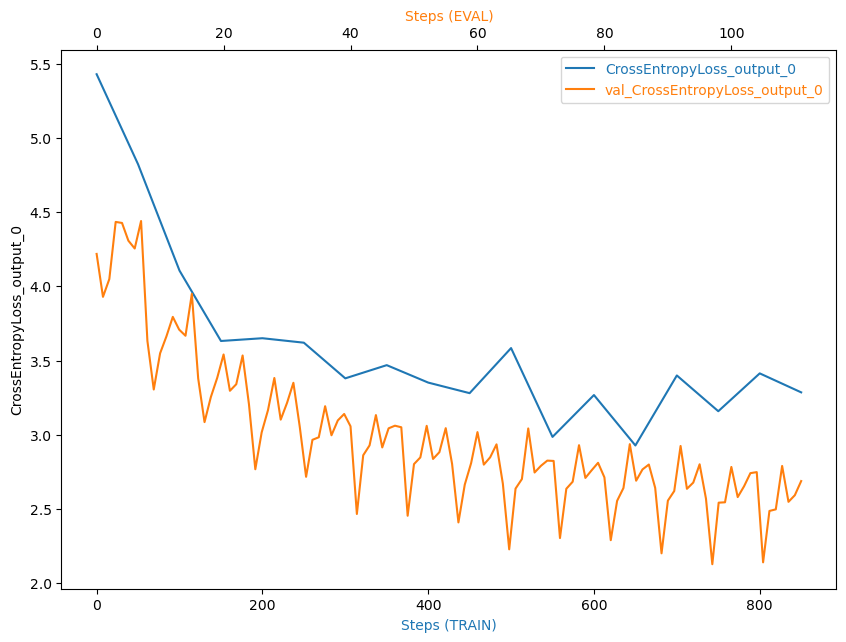

In [16]:
# Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

plot_tensor(trial, "CrossEntropyLoss_output_0")



**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?
- Base on the plot, we could see that the validation loss is fluctuating significantly, indicating noisy or unstable evaluation. This could be due to: Overfitting, Inconsistent Data Augmentation or Small Validation Dataset
- To resolved it, maybe we should remove Validation-Train Augmentation Mismatch to avoiding heavy augmentation for training. Use a learning rate scheduler (e.g., torch.optim.lr_scheduler.StepLR) to dynamically adjust the learning rate and monitor the overfitting

In [17]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-172446954990/pytorch-training-2024-11-21-17-11-44-262/rule-output


In [18]:
! aws s3 ls {rule_output_path} --recursive

2024-11-21 17:33:45     416437 pytorch-training-2024-11-21-17-11-44-262/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-11-21 17:33:44     272096 pytorch-training-2024-11-21-17-11-44-262/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-11-21 17:33:40        571 pytorch-training-2024-11-21-17-11-44-262/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-11-21 17:33:40      19217 pytorch-training-2024-11-21-17-11-44-262/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-11-21 17:33:40       1933 pytorch-training-2024-11-21-17-11-44-262/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-11-21 17:33:40        325 pytorch-training-2024-11-21-17-11-44-262/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-11-21 17:33:40        466 pytorch-training-2024-11-21-17-11-44-262/rule-output/ProfilerReport/profiler-output/profiler-re

In [19]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-172446954990/pytorch-training-2024-11-21-17-11-44-262/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-172446954990/pytorch-training-2024-11-21-17-11-44-262/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-172446954990/pytorch-training-2024-11-21-17-11-44-262/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-172446954990/pytorch-training-2024-11-21-17-11-44-262/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-172446954990/pytorc

In [20]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [21]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [22]:
# TODO: Deploy your model to an endpoint
from sagemaker.pytorch import PyTorch
estimator = PyTorch.attach("pytorch-training-241121-1612-004-fe7102d5")


2024-11-21 16:52:14 Starting - Found matching resource for reuse
2024-11-21 16:52:14 Downloading - Downloading the training image
2024-11-21 16:52:14 Training - Training image download completed. Training in progress.
2024-11-21 16:52:14 Uploading - Uploading generated training model
2024-11-21 16:52:14 Completed - Resource released due to keep alive period expiry


In [23]:
predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.g4dn.xlarge")
predictor

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-172446954990/pytorch-training-241121-1612-004-fe7102d5/output/model.tar.gz), script artifact (s3://sagemaker-us-east-1-172446954990/pytorch-training-2024-11-21-16-12-46-777/source/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-172446954990/pytorch-training-2024-11-21-17-48-33-550/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-training-2024-11-21-17-48-33-550
INFO:sagemaker:Creating endpoint-config with name pytorch-training-2024-11-21-17-48-33-550
INFO:sagemaker:Creating endpoint with name pytorch-training-2024-11-21-17-48-33-550


------------!

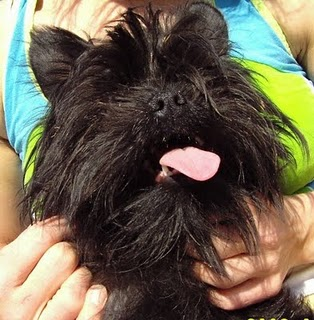

In [30]:
from PIL import Image
img = Image.open("dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg")
img

In [31]:
import torchvision.transforms as transforms

def process_image(image):    
    img = image.convert('RGB')
    data_transform = transforms.Compose(
        [transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
    )

    return data_transform(img)[:3,:,:].unsqueeze(0).numpy()

img_processed = process_image(img)

In [32]:
import numpy as np
response = predictor.predict(img_processed)
print("Prediction result with processing:")
print(np.argmax(response[0]) + 1)

Prediction result with processing:
1


In [33]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-training-2024-11-21-17-48-33-550
INFO:sagemaker:Deleting endpoint with name: pytorch-training-2024-11-21-17-48-33-550
